# Cygnus X seen by $\Delta$-variance

In [1]:
import aplpy
from astropy.io import fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', **{'family': 'serif', 'size': 20})
plt.rc('lines', linewidth = 2.5)
plt.rc('text', usetex=True)

INFO: Auto-setting vmin to  4.266e+21 [aplpy.core]
INFO: Auto-setting vmax to  3.195e+22 [aplpy.core]


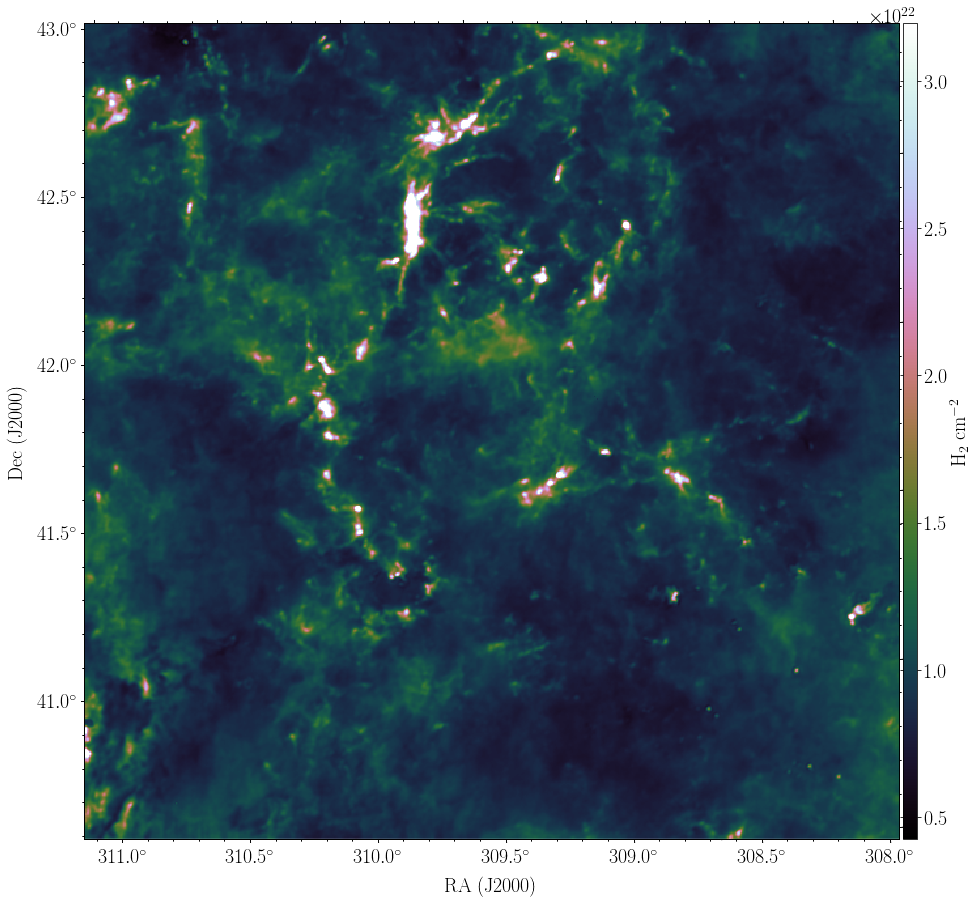

In [3]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/Users/robitaij/postdoc/Herschel/HOBYS_coldens/dr21_coldens_cf_r500_medsmo3_proj.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all, convention='calabretta')
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(0.5)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [5]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

#Remove NaN
im[np.where(im != im)] = 0.

In [4]:
from pywavan import fan_trans, apodize, padding, depad, powspec, gauss_beam

## Plot Fourier and wavelet power spectra

The package pywavan is designed to calculate the Fourier power spectrum as well as its equivalent wavelet power spectrum using the complexe Morlet wavelet.

The segmented wavelet power spectra can be calculated by averaging the square absolute value of complex wavelet coefficients as a function of spatial scales

\begin{equation}
P(\ell)=\frac{\delta \theta}{N_{\theta}N_{\mathbf{x}}} \sum_{\mathbf{x}} \sum_{j=0}^{N_{\theta}-1}  |\tilde{f}(\ell,\mathbf{x},\theta_j)|^2,
\label{eq:Fan_wavelet}
\end{equation}

where $N_{\theta}=\Delta \theta/\delta \theta$ is the number of directions $\theta$ needed to sample the Fourier space over the range $\Delta \theta$ and $N_{\mathbf{x}}$ is the number of pixels in the image.

The Fourier transform is defined as 

\begin{equation}
\tilde{f}(\ell,\mathbf{x})= \frac{1}{\ell} \int \int_{-\infty}^{+\infty} f(\mathbf{x}')\psi^*\Big(\frac{\mathbf{x}'-\mathbf{x}}{\ell}\Big)d\mathbf{x}'.
\label{eq:wavelet_transform}
\end{equation}

800 800


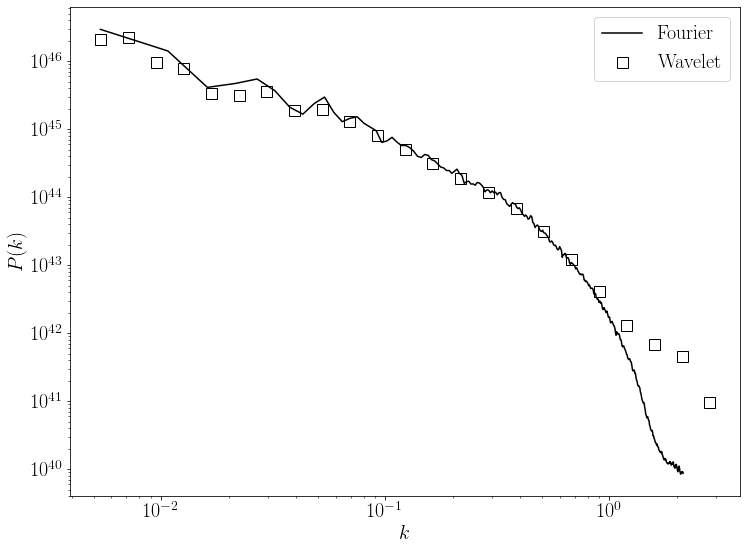

In [8]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]
meanim = np.mean(im)
imzm = im - meanim

#Apodization
newdim = np.array((800,800))
tapper = apodize(nb,na,0.98)
imt = imzm *tapper
imr = padding(imt,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=0, arrdim = newdim, smooth=False, angular=False)

#Plot
plt.figure(figsize=(12,9))
plt.plot(tab_k, spec_k, color='black',label='Fourier', linewidth=1.5)
plt.plot(wav_k, S1a,'s', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Wavelet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$P(k)$")
plt.legend()

In the case of the Cygnus X region, compared to the analysis of Polaris in Robitaille et al. 2019, the power law is much more flatter and the lower spectral resolution of wavelets at small scales seems to have a hard time to capture the abrupt drop of power caused by the telescope beam.

Nonetheless, as for the Fourier power spectrum, the wavelet power spectrum of the telescope beam can be divided to observations since the convoltion operation becomes simply a multiplication on the Fourier space.

Text(0.5, 1.0, 'Beam power spectrum')

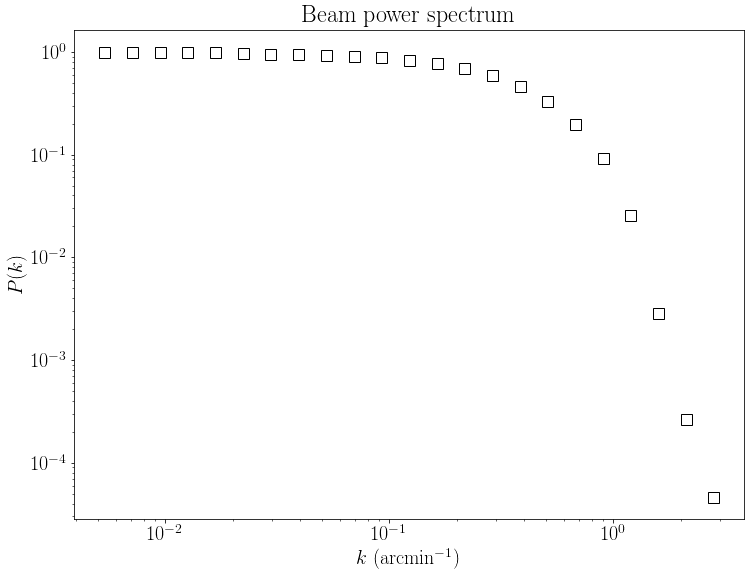

In [12]:
#Wavelet power spectrum of the telescope beam

beam = fits.open('/Users/robitaij/postdoc/Herschel/beams/empiral_spire_beam_500.fits')[0].data
beamr = padding(beam,newdim[0],newdim[1])

Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beamr, reso=reso, q=0, smooth=False)
del Bwt, BS11a, Bwav_k, Bq

#Spectrum normalisation
BS1an = BS1a / BS1a[3]
BS1an[:3] = 1.0 

plt.figure(figsize(12,9))
plt.plot(wav_k, BS1an,'s', markersize = 11, markerfacecolor='none', markeredgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.title('Beam power spectrum')

Plot corrected power spectrum

Power law fit
A, Gamma =  3.671183136513015e+43 -1.3573171438289544
Uncertainties =  1.0346320881698048 0.018265854613605047


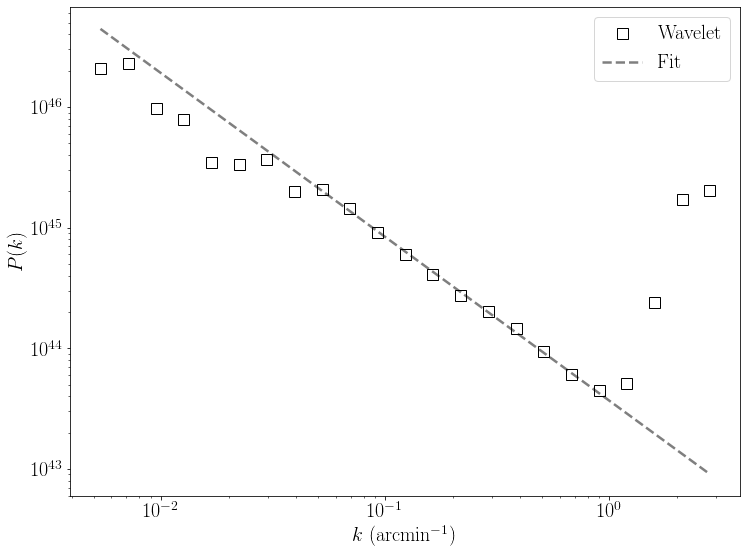

In [24]:
#Power spectra fits
A, cov = np.polyfit(np.log(wav_k[8:18]), np.log(S1a[8:18]/BS1an[8:18]),deg=1,cov=True)
fit = np.exp(A[1])*wav_k**A[0]
print('Power law fit')
print('A, Gamma = ', np.exp(A[1]), A[0])
print('Uncertainties = ', np.exp(np.sqrt(np.diag(cov)[1])), np.sqrt(np.diag(cov)[0]))

#Plot
plt.figure(figsize=(12,9))
plt.plot(wav_k, S1a/BS1an,'s', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Wavelet')
plt.plot(wav_k, fit,'--',color='black',label=r'Fit', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r"$P(k)$")
plt.legend()

The division redressed the power spectrum towards the small scale until the signal becomes dominated by the flat noise level. The fitted power law is -1.35. The noise level creates the small plateau at the very end of the original power spectrum.

## Pywavan vs $\Delta$-variance

Bensch et al. 2001 defined the $\Delta$-variance as:

$$\sigma^2_{\Delta}(L) = \frac{1}{2\pi}\langle \left( f(\mathbf{x}) * \psi_L(\mathbf{x})\right)^2\rangle_{\mathbf{x}}$$

where $*$ is the convolution. This relation is really close to the wavelet power spectrum defined above. The main difference seems to be in the definition of the convolution itself, where the $\Delta$-variance does not normalise with $1/L$ (or $1/\ell$).

The $\Delta$-variance spectra are also plotted as a function of $L = (2\pi k)^{-1}$.

Using the flag "pownorm=False" the function "fan_trans" does not normalise the power by $1/L^2$.

The power spectrum power law $\beta$ should be related to the delta variance value through the relation

$$d_{\Delta} = \beta - 2$$

In [74]:
#Wavelet power spectrum
wt, S11a, wav_k, S1aN, q = fan_trans(im, reso=reso, q=0, arrdim = newdim, pownorm=False)

800 800


Power law fit
A, Gamma =  1.5736254445346511e+40 -0.29208856766873836
Uncertainties =  1.0064096176380752 0.027419694445829233
Beta = 1.7079114323312616


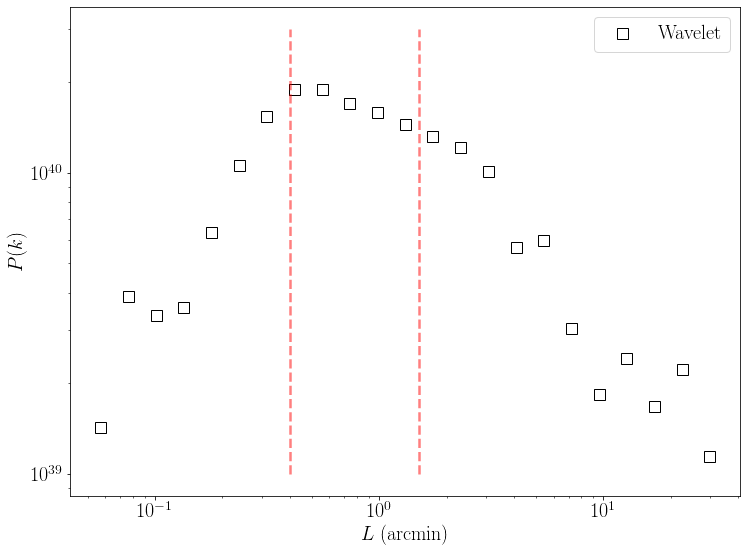

In [75]:
#Power spectra fits
A, cov = np.polyfit(np.log(1./(2*np.pi*wav_k[11:14])), np.log(S1aN[11:14]),deg=1,cov=True)
fit = np.exp(A[1])*wav_k**A[0]
print('Power law fit')
print('A, Gamma = ', np.exp(A[1]), A[0])
print('Uncertainties = ', np.exp(np.sqrt(np.diag(cov)[1])), np.sqrt(np.diag(cov)[0]))

print('Beta =',A[0]+2.)

#Plot
plt.figure(figsize=(12,9))
plt.plot(1./(2*np.pi*wav_k), S1aN,'s', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Wavelet')
plt.plot([0.4,0.4],[1e39,3e40],'--',color='red',alpha=0.5)
plt.plot([1.5,1.5],[1e39,3e40],'--',color='red',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L$ (arcmin)')
plt.ylabel(r"$P(k)$")
plt.legend()

The two red dashed lines are the fit limits assigned in Nicola's paper. Within this limit we measure $\beta = 1.70$.

Power law fit
A, Gamma =  2.1545258502761102e+40 -0.6426828561710787
Uncertainties =  1.0153242461329552 0.01826585461360064
Beta = 1.3573171438289213


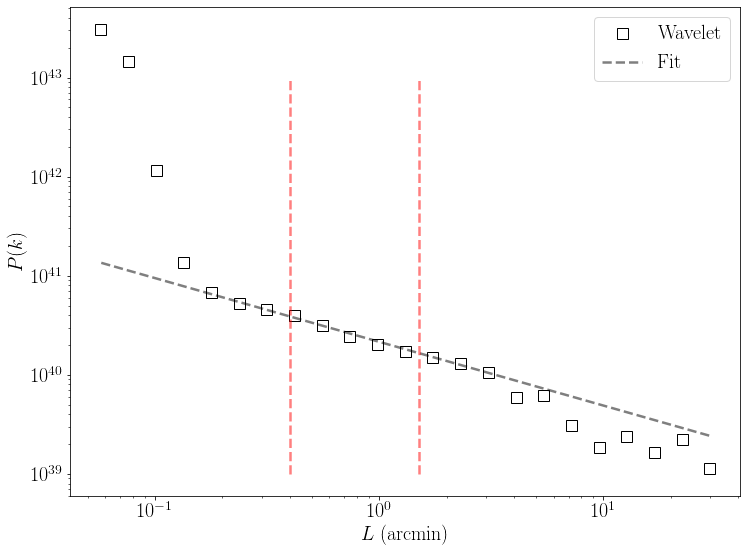

In [53]:
#Power spectra fits
A, cov = np.polyfit(np.log(1./(2*np.pi*wav_k[8:18])), np.log(S1aN[8:18]/(BS1aN2[8:18]*a[8:18]**2.)),deg=1,cov=True)
fit = np.exp(A[1])*1./(2*np.pi*wav_k)**A[0]
print('Power law fit')
print('A, Gamma = ', np.exp(A[1]), A[0])
print('Uncertainties = ', np.exp(np.sqrt(np.diag(cov)[1])), np.sqrt(np.diag(cov)[0]))

print('Beta =',A[0]+2.)

#Plot
plt.figure(figsize=(12,9))
plt.plot(1./(2*np.pi*wav_k), S1aN/(BS1an),'s', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Wavelet')
plt.plot(1./(2*np.pi*wav_k), fit,'--',color='black',label=r'Fit', alpha=0.5)
plt.plot([0.4,0.4],[1e39,1e43],'--',color='red',alpha=0.5)
plt.plot([1.5,1.5],[1e39,1e43],'--',color='red',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L$ (arcmin)')
plt.ylabel(r"$P(k)$")
plt.legend()

In [ ]:
Once divided by the beam, we retrieve a similar spectrum then the wavelet power spectrum with the same $\beta = 1.35$""